# **Diamonds Price Prediction**
This notebook focuses on building a predictive regression model to estimate the sales price of diamonds based on their characteristics. The workflow includes preparing the data, selecting relevant features, and training machine learning models to achieve accurate predictions.

## CONTENTS
    1. Importing Libraries

    2. Data Loading and Preprocessing
        - Load data
        - Data Cleaning: 
            i)   Handle Duplicate and Missing Values
            ii)  Handle Inconsistent Categorical Data
            iii) Handle Outliers
        - Encoding

    3. Model Training
        - Base Model

    4. Model Optimization:
        i)   Feature Engineering
        ii)  Normalization
        iii) Model Selection?
    
    5. Visualization

## 1. Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import (
    train_test_split, 
    cross_validate, cross_val_score,
    KFold, GridSearchCV, RandomizedSearchCV)

from sklearn.preprocessing import (
    StandardScaler,RobustScaler,
    MinMaxScaler, 
    QuantileTransformer, quantile_transform,
    Normalizer, power_transform, PowerTransformer,
    PolynomialFeatures, 
    OneHotEncoder, OrdinalEncoder, LabelEncoder)
from sklearn.impute import SimpleImputer

from sklearn.linear_model import (
    LinearRegression, Ridge, RidgeCV, Lasso, SGDRegressor)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, \
    GradientBoostingRegressor, AdaBoostRegressor, \
        ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sklearn.metrics import (
    mean_squared_error, r2_score,
    mean_absolute_error, mean_absolute_percentage_error, 
    median_absolute_error, make_scorer)

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import (
    make_column_transformer, TransformedTargetRegressor, 
    make_column_selector, ColumnTransformer)

from sklearn import svm
from sklearn.svm import SVR, SVC
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

rng = np.random.RandomState(42)

## 2. Data Loading and Preprocessing

In [2]:
# Data Loading
df = pd.read_csv('data/diamonds.csv')
df.head()

,Unnamed: 0,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,...,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,...,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,...,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200


### Data Cleaning

#### i)Handle Duplicate and Missing Values

In [3]:
# Drop the first column
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,meas_depth,girdle_min,girdle_max,fluor_color,fluor_intensity,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,N,...,1.79,M,M,unknown,NaN,unknown,unknown,unknown,unknown,200
1,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Very Good,unknown,N,...,1.78,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
2,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,...,1.77,TN,M,unknown,NaN,unknown,unknown,unknown,unknown,200
3,Round,E,VVS2,0.09,Excellent,IGI,Very Good,Very Good,unknown,unknown,...,1.78,M,STK,unknown,NaN,unknown,unknown,unknown,unknown,200
4,Round,E,VVS2,0.09,Very Good,IGI,Very Good,Excellent,unknown,N,...,1.82,STK,STK,unknown,NaN,unknown,unknown,unknown,unknown,200


In [4]:
# Check for missing values
df.isnull().sum()

cut                                 0
color                               0
clarity                             0
carat_weight                        0
cut_quality                         0
lab                                 0
symmetry                            0
polish                              0
eye_clean                           0
culet_size                          0
culet_condition                     0
depth_percent                       0
table_percent                       0
meas_length                         0
meas_width                          0
meas_depth                          0
girdle_min                          0
girdle_max                          0
fluor_color                         0
fluor_intensity                143491
fancy_color_dominant_color          0
fancy_color_secondary_color         0
fancy_color_overtone             1650
fancy_color_intensity               0
total_sales_price                   0
dtype: int64

In [5]:
# Fluorescence Intenity has a lot of missing values, so we can drop it
df.drop('fluor_intensity', axis=1, inplace=True)
# Replace NaN with 'unknown' in the remaining columns
df.replace(np.nan, 'unknown', inplace=True)

In [6]:
# Drop duplicate entries
print(df.duplicated().sum())
df.drop_duplicates(inplace=True, ignore_index=True)
df.shape

3911


(215792, 24)

#### ii) Handle Inconsistent Categorical Data

In [7]:
# Check for invalid data points
# 1. Diamonds with a color grade and a fancy color dominant color
display(df.loc[(df['color']!='unknown') & (df['fancy_color_dominant_color']!='unknown')])

# 2. Diamonds with a color grade and a fancy color overtone
display(df.loc[(df['color']!='unknown') & (df['fancy_color_overtone']!='unknown')])

# 3. Diamonds with an unknown color grade and an unknown fancy color dominant color
display(df.loc[(df['color']=='unknown') & (df['fancy_color_dominant_color']=='unknown')])

# 4. Diamonds of an invalid clarity grade i.e, SI3  
display(df.loc[(df['clarity']=='SI3')])

,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,meas_width,meas_depth,girdle_min,girdle_max,fluor_color,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
7633,Round,M,VVS1,0.33,Excellent,GIA,Excellent,Excellent,unknown,unknown,...,4.49,2.72,unknown,unknown,Blue,Other,unknown,unknown,unknown,618
147126,Oval,M,VVS2,0.81,unknown,GIA,Very Good,Excellent,unknown,N,...,4.60,2.80,unknown,unknown,unknown,Other,unknown,unknown,unknown,3802


,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,meas_width,meas_depth,girdle_min,girdle_max,fluor_color,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
9144,Round,K,VVS2,0.30,Excellent,GIA,Excellent,Excellent,unknown,unknown,...,4.29,2.68,unknown,unknown,unknown,unknown,unknown,Yellowish,unknown,624
149668,Pear,D,SI1,0.77,unknown,GIA,Very Good,Very Good,unknown,unknown,...,4.88,3.37,STK,XTK,unknown,unknown,unknown,Greenish,unknown,3882
151338,Pear,D,VS2,0.73,unknown,GIA,Very Good,Very Good,unknown,unknown,...,4.89,3.42,TK,XTK,unknown,unknown,unknown,Greenish,unknown,4119
157003,Round,K,VS2,1.10,Excellent,IGI,Excellent,Excellent,unknown,unknown,...,6.52,4.11,STK,STK,unknown,unknown,unknown,Brownish,unknown,4754
215310,Round,D,VVS2,5.05,Excellent,GIA,Excellent,Excellent,unknown,N,...,11.30,6.66,unknown,unknown,Blue,unknown,unknown,Yellowish,unknown,233311
215346,Round,E,VVS1,5.49,Excellent,GIA,Excellent,Excellent,unknown,N,...,11.32,6.95,unknown,unknown,Blue,unknown,unknown,Yellowish,unknown,245952


,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,meas_width,meas_depth,girdle_min,girdle_max,fluor_color,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price


,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,meas_width,meas_depth,girdle_min,girdle_max,fluor_color,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
128,Round,H,SI3,0.23,Very Good,IGI,Very Good,Very Good,unknown,unknown,...,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,284
147,Round,H,SI3,0.24,Very Good,IGI,Very Good,Very Good,unknown,unknown,...,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,296
169,Round,H,SI3,0.25,Very Good,IGI,Very Good,Very Good,unknown,unknown,...,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,308
210,Round,H,SI3,0.26,Very Good,IGI,Very Good,Very Good,unknown,unknown,...,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,320
226,Round,F,SI3,0.24,Very Good,IGI,Very Good,Very Good,unknown,unknown,...,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,324
290,Round,H,SI3,0.27,Very Good,IGI,Very Good,Very Good,unknown,unknown,...,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,334
390,Round,H,SI3,0.29,Very Good,IGI,Very Good,Very Good,unknown,unknown,...,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,358
9514,Round,G,SI3,0.30,Very Good,IGI,Very Good,Very Good,unknown,unknown,...,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,630
18972,Round,F,SI3,0.32,Very Good,IGI,Very Good,Very Good,unknown,unknown,...,0.0,0.0,unknown,unknown,unknown,unknown,unknown,unknown,unknown,720


In [8]:
# 1. Changing 'Other' value to unknown in fancy_color_dominant_color field
df['fancy_color_dominant_color'] = df['fancy_color_dominant_color'].replace('Other', 'unknown')

# 2. D, E, F are colorless diamonds, K, L, M are faint yellow diamonds so we can remove fancy color
# overtone for the colorless diamonds.
df.loc[(df['color']=='D') | (df['color']=='E'), 'fancy_color_overtone'] = 'unknown'

# 4. SI3 is not a valid clarity grade, it should be I1 
# https://beyond4cs.com/clarity/si3-grading/
df['clarity'] = df['clarity'].replace('SI3', 'I1')

In [9]:
# OR NOT
# # Reduce the number of clarity grades to 5
# def clarity_condition(clarity):
#     if clarity in ['VVS1', 'VVS2']:
#         return 'VVS'
#     elif clarity in ['VS1', 'VS2']:
#         return 'VS'
#     elif clarity in ['SI1', 'SI2']:
#         return 'SI'
#     elif clarity in ['I1', 'I2', 'I3']:
#         return 'I'
#     elif clarity in ['IF']:
#         return 'IF'
#     else:
#         return 'unknown'

# # Reduce the number of color grades
# def color_condition(color):
#     if color in ['D', 'E', 'F']:
#         return 'colorless'
#     elif color in ['G', 'H', 'I', 'J']:
#         return 'near colorless'
#     elif color in ['K', 'L', 'M']:
#         return 'faint color'
#     else:
#         return 'unknown'

# df['clarity'] = df['clarity'].apply(clarity_condition)
# df['color'] = df['color'].apply(color_condition)


In [10]:
categorical_columns = [x for x in df.columns if df[x].dtype == 'object']
numeric_columns = [x for x in df.columns if df[x].dtype != 'object']
print(len(categorical_columns))

17


#### iii) Handle Outliers

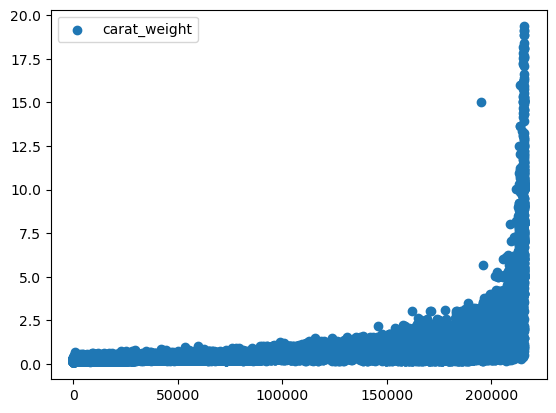

C:\Users\tsree\AppData\Local\Temp\ipykernel_27368\1178365760.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outliers_df = pd.concat([outliers_df, df.loc[(df[col]==0)]])


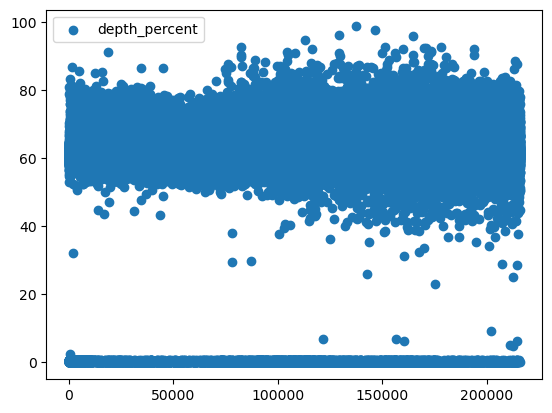

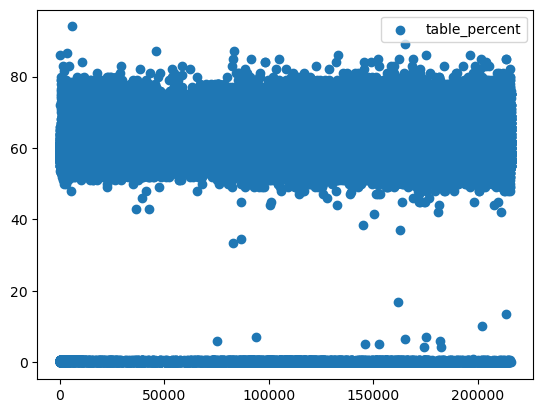

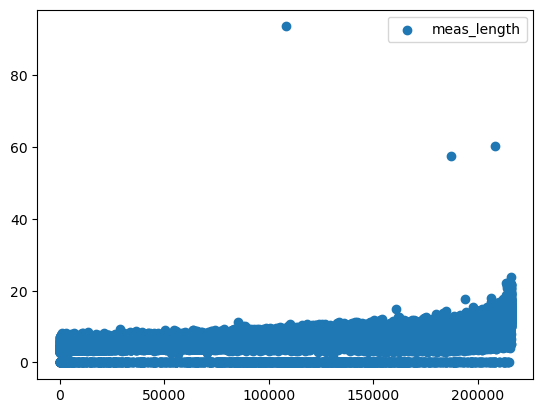

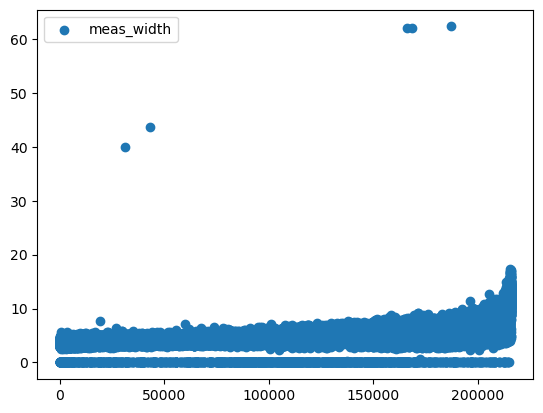

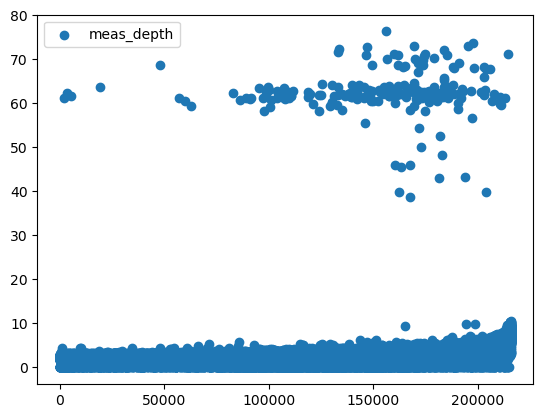

In [11]:
# Finding outliers
outliers_df = pd.DataFrame(columns=list(df))

for col in list(df):
    if df[col].dtypes == 'float64':
        # Add data points with a value of 0 for any numeric column to the outliers dataframe
        outliers_df = pd.concat([outliers_df, df.loc[(df[col]==0)]])
        plt.scatter(df.index, df[col], label=col) 
        plt.legend()
        plt.show() 

In [12]:
# Drop outliers from the above scatter plots
outliers_df = pd.concat([outliers_df, df.loc[(df['meas_depth']>30) | (df['meas_width']>30) | 
                (df['meas_length']>40) | (df['depth_percent']<20) | (df['table_percent']<20)]])
print(outliers_df.shape)

(17471, 24)


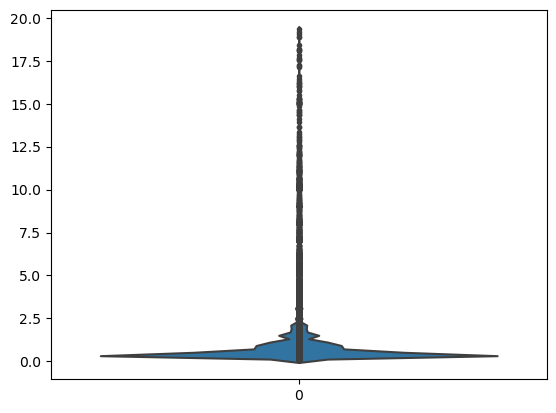

In [13]:
# Detect outliers of carat_weight
sns.violinplot(df['carat_weight'], inner='points', )
plt.show()

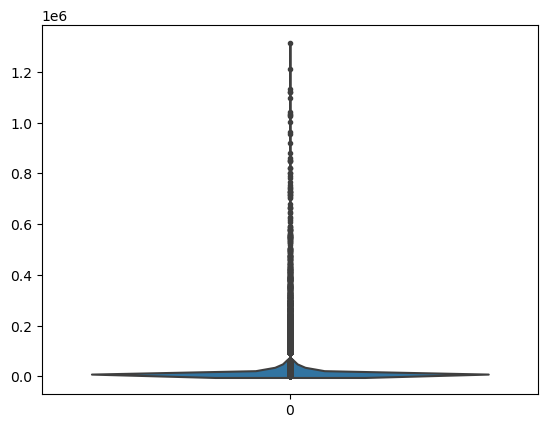

In [14]:
# Detect outliers of total_sales_price
# Since we know fancy color diamonds cost more, 
# we can find any colorless diamonds that are outliers
sns.violinplot(df.loc[(df['color']!='unknown')]['total_sales_price'], inner='points', )
plt.show()

In [15]:
# Drop outliers from the above plots
temp_df = df.loc[(df['color']!='unknown')]
outliers_df = pd.concat([outliers_df, temp_df.loc[(temp_df['carat_weight']>7.5)]])
print(outliers_df.shape)

df = df.drop(outliers_df.index).reset_index(drop=True)
print(df.shape)

(17848, 24)
(209114, 24)


In [16]:
df_clean = df.copy()

In [17]:
# Save cleaned dataframe
df_clean.to_pickle('data/modeling_cleaned.pkl')

### Encoding

In [18]:
cat_values = pd.DataFrame(df[categorical_columns].apply(lambda x: x.unique().tolist()))
with pd.option_context('display.max_colwidth', 1):
    display(cat_values)

,0
cut,"[Round, Pear, Oval, Marquise, Princess, Emerald, Heart, Radiant, Cushion Modified, Cushion, Asscher]"
color,"[E, F, D, I, G, H, M, L, J, K, unknown]"
clarity,"[VVS2, VVS1, VS1, VS2, IF, SI2, I2, SI1, I1, I3]"
cut_quality,"[Excellent, Very Good, unknown, Good, Fair, Ideal]"
lab,"[IGI, GIA, HRD]"
symmetry,"[Very Good, Excellent, Good, Fair, Poor]"
polish,"[Very Good, Excellent, Good, Fair, Poor]"
eye_clean,"[unknown, Yes, E1, Borderline, No]"
culet_size,"[N, unknown, S, M, VS, L, EL, SL, VL]"
culet_condition,"[unknown, Abraded, Chipped, Pointed]"


In [19]:
# Label Encoding
le = LabelEncoder()
df[categorical_columns] = df[categorical_columns].apply(le.fit_transform)
df.head()

,cut,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,...,meas_width,meas_depth,girdle_min,girdle_max,fluor_color,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,10,1,9,0.09,0,2,4,4,4,3,...,2.87,1.79,0,0,5,11,10,7,9,200
1,10,1,9,0.09,4,2,4,4,4,3,...,2.89,1.78,1,1,5,11,10,7,9,200
2,10,1,9,0.09,0,2,4,4,4,8,...,2.90,1.77,4,0,5,11,10,7,9,200
3,10,1,9,0.09,0,2,4,4,4,8,...,2.88,1.78,0,1,5,11,10,7,9,200
4,10,1,9,0.09,4,2,4,0,4,3,...,2.83,1.82,1,1,5,11,10,7,9,200


## 3. Modeling

### Base Model
Let us train a Linear Regression Model with all the features and measure the errors to assess the base models' accuracy.

In [20]:
# Define a function to split the data into train and test sets
def split_data(given_df, shuffle=True):
    # Split the data into train and test sets
    X, y = given_df.drop('total_sales_price', axis=1), given_df['total_sales_price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=shuffle)

    return X_train, X_test, y_train, y_test


# Define a function to fit and evaluate the model 
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    clf = model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = clf.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"RMSE: {rmse}")
    print(f"R^2: {r2}")
    print(f"MAE: {mae}")
    print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))
    return clf


# Define a function to plot the model 
def plot_model(model, X_test, y_test):
    # Plot the model
    y_pred = model.predict(X_test)
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual Sales Price')
    plt.ylabel('Predicted Sales Price')
    plt.show()


# Define a function to plot the fit 
def plot_fit(model, X_test, y_test, num_of_points=150):
    # Plot the model
    y_pred = model.predict((X_test))
    y_test_numpy = y_test.to_numpy()

    n = int((y_test_numpy.shape[0])*0.8)
    
    plt.figure(figsize=(50,10))
    plt.plot(y_pred[n:n+num_of_points], 'b+-', label='predicted', linewidth=3)
    plt.plot(y_test_numpy[n:n+num_of_points],'ro--',label='actual', linewidth=3)
    plt.legend()
    plt.show()


# Plot the residuals
def plot_residuals(model, X_test, y_test):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    plt.scatter(y_test, residuals)
    plt.xlabel('Actual')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Actual')
    plt.show()



# Define a function to save the model
def save_model(model, model_name):
    pickle.dump(model, open('data/' + model_name + '.pkl', 'wb'))

In [21]:
from sklearn.base import BaseEstimator, RegressorMixin

class SMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model_class, formula):
        self.model_class = model_class
        self.formula = formula
    
    def fit(self, X, y):
        self.model = self.model_class(self.formula, data=X).fit()
        return self
    
    def predict(self, X):
        return self.model.predict(X)

RMSE: 10977.30174494771
R^2: 0.6331711306478167
MAE: 3036.945518290207
MAPE:  1.1652289166836154
Train MAE of the Base Model: 3138.0194160724104 +/- 42.56048162488066
Best alpha: 46.41588833612773


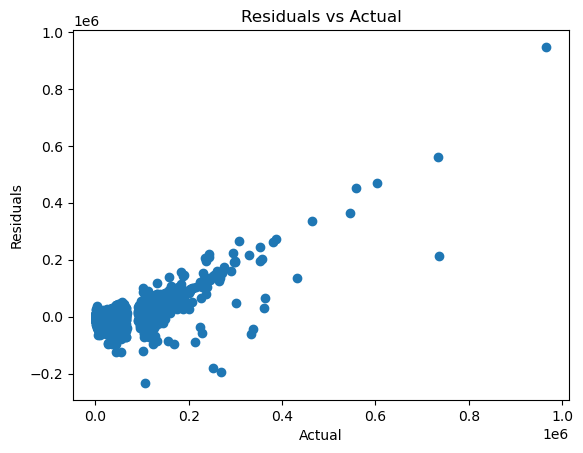

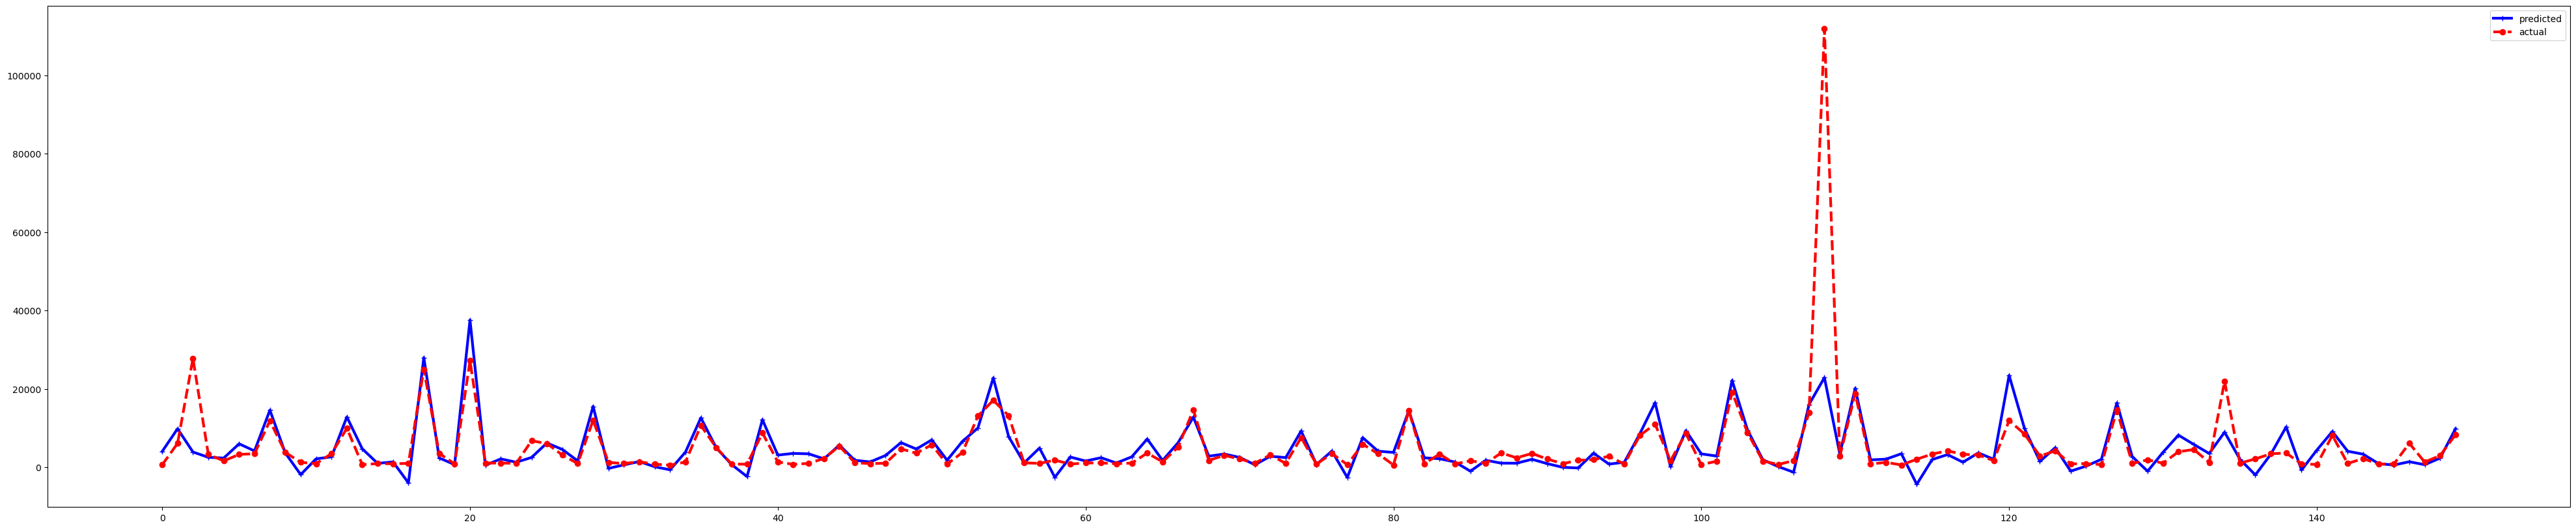

In [22]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = split_data(df_clean)
df_train = pd.DataFrame(pd.concat([X_train, y_train], axis=1))
df_test = pd.DataFrame(pd.concat([X_test, y_test], axis=1))
numeric_X_columns = X_train.select_dtypes(exclude='object').columns

# Encode categorical columns with a baseline OrdinalEncoder
categorical_transformer =Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler(with_mean=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_X_columns),
        ('cat', categorical_transformer, categorical_columns)],
        remainder='passthrough',
        verbose_feature_names_out=False)

# Individual preprocessors
base_encoder = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
     X_train.select_dtypes(include='object').columns),
    remainder='passthrough',
    verbose_feature_names_out=False
)
scalar = StandardScaler(with_mean=False)

# Define the model
mae_scorer = make_scorer(mean_absolute_error)
cv2 = KFold(n_splits=5, shuffle=True, random_state=rng)

base_model = make_pipeline(
    preprocessor,
    RidgeCV(alphas=np.logspace(-3, 3, 10),cv=cv2)
)

# Train and evaluate the model
clf = evaluate_model(base_model, X_train, X_test, y_train, y_test)
scores2 = cross_val_score(clf, X_train, y_train, scoring='neg_mean_absolute_error')
scores2 = -scores2
print(f'Train MAE of the Base Model: {scores2.mean()} +/- {scores2.std()}')

# Print the alpha value
print(f"Best alpha: {clf.named_steps['ridgecv'].alpha_}")

# Save the model
save_model(clf, 'base_model')

# Plot the model
# plot_model(clf, X_test, y_test)

# Plot the residuals
plot_residuals(clf,  X_test, y_test)

# Plot the fit
plot_fit(clf, X_test, y_test)

In [23]:
# print(base_model.named_steps['ridgecv'].coef_)

## 4. Model Optimization

In [24]:
# check for multicollinearity
vif = pd.DataFrame()
temp_X = pd.DataFrame(scalar.fit_transform(X_train[numeric_X_columns]))

vif["features"] = scalar.feature_names_in_
vif["VIF Factor"] = [variance_inflation_factor(temp_X.values, i) for i in range(len(numeric_X_columns))]
vif.sort_values("VIF Factor", ascending=False)
vif

,features,VIF Factor
0,carat_weight,6.665396
1,depth_percent,8.097995
2,table_percent,1.311849
3,meas_length,3.509740
4,meas_width,116.098616
5,meas_depth,121.788340


We see that meas_width and meas_depth are highly correlated. Lets check if any other predictors have high colinearity.

c:\Users\tsree\anaconda3\envs\pybasics\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

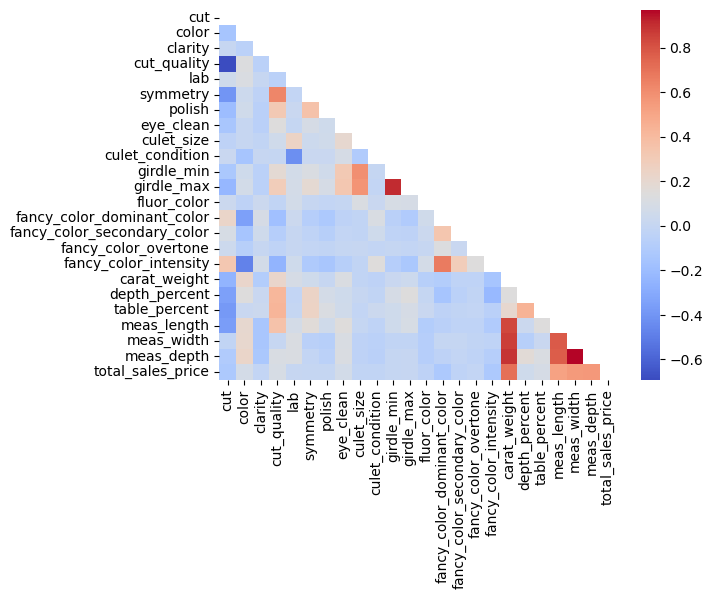

In [25]:
# Check for multicollinearity using correlation matrix
df_temp = pd.DataFrame(base_encoder.fit_transform(df_train), 
                       columns=base_encoder.get_feature_names_out())
correlation_matrix = df_temp.corr()

# Round the correlation matrix
correlation_matrix_round = correlation_matrix.round(2)
# Create mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix_round, dtype=bool))
upper_corr = correlation_matrix_round.mask(mask)
upper_corr.columns = df_temp.columns

# Plot the correlation matrix
# print(upper_corr)
sns.heatmap(upper_corr, cmap='coolwarm', annot=True)

Features to be dropped:
- girdle_min
- cut
- meas_depth
- meas_width

In [31]:
df_processed = df_clean.drop(['girdle_min', 'cut', 'meas_depth', 'meas_width'], axis=1)
df_processed_enc = df_processed.copy()

categorical_columns = df_processed.select_dtypes(include='object').columns

df_temp = pd.DataFrame(categorical_transformer.fit_transform(df_processed[categorical_columns]), 
                       columns=categorical_transformer.get_feature_names_out())

df_processed_enc[categorical_columns] = df_temp
df_processed_enc

,color,clarity,carat_weight,cut_quality,lab,symmetry,polish,eye_clean,culet_size,culet_condition,depth_percent,table_percent,meas_length,girdle_max,fluor_color,fancy_color_dominant_color,fancy_color_secondary_color,fancy_color_overtone,fancy_color_intensity,total_sales_price
0,1.0,9.0,0.09,0.0,2.0,4.0,4.0,4.0,3.0,3.0,62.7,59.0,2.85,0.0,5.0,11.0,10.0,7.0,9.0,200
1,1.0,9.0,0.09,4.0,2.0,4.0,4.0,4.0,3.0,3.0,61.9,59.0,2.84,1.0,5.0,11.0,10.0,7.0,9.0,200
2,1.0,9.0,0.09,0.0,2.0,4.0,4.0,4.0,8.0,3.0,61.1,59.0,2.88,0.0,5.0,11.0,10.0,7.0,9.0,200
3,1.0,9.0,0.09,0.0,2.0,4.0,4.0,4.0,8.0,3.0,62.0,59.0,2.86,1.0,5.0,11.0,10.0,7.0,9.0,200
4,1.0,9.0,0.09,4.0,2.0,4.0,0.0,4.0,3.0,3.0,64.9,58.5,2.79,1.0,5.0,11.0,10.0,7.0,9.0,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209109,10.0,8.0,10.00,5.0,0.0,4.0,0.0,4.0,8.0,3.0,78.1,60.0,11.78,9.0,5.0,10.0,10.0,7.0,6.0,1124122
209110,10.0,6.0,10.04,5.0,0.0,0.0,0.0,4.0,8.0,3.0,72.8,55.0,14.13,9.0,5.0,10.0,10.0,7.0,6.0,1161102
209111,10.0,7.0,5.17,5.0,0.0,4.0,4.0,4.0,8.0,3.0,64.8,65.0,11.55,7.0,5.0,5.0,10.0,7.0,5.0,1292500
209112,10.0,5.0,0.90,5.0,0.0,2.0,2.0,4.0,3.0,3.0,70.8,72.0,5.22,5.0,5.0,9.0,10.0,7.0,1.0,1350000


total_sales_price              1.000000
carat_weight                   0.721654
meas_length                    0.527175
fancy_color_intensity          0.122570
fancy_color_dominant_color     0.115418
cut_quality                    0.098482
table_percent                  0.090230
color                          0.077683
eye_clean                      0.066365
depth_percent                  0.052488
fluor_color                    0.035856
fancy_color_secondary_color    0.034864
culet_condition                0.024516
culet_size                     0.017238
fancy_color_overtone           0.014495
lab                            0.014492
clarity                        0.013892
girdle_max                     0.010800
symmetry                       0.001324
polish                         0.001215
Name: total_sales_price, dtype: float64


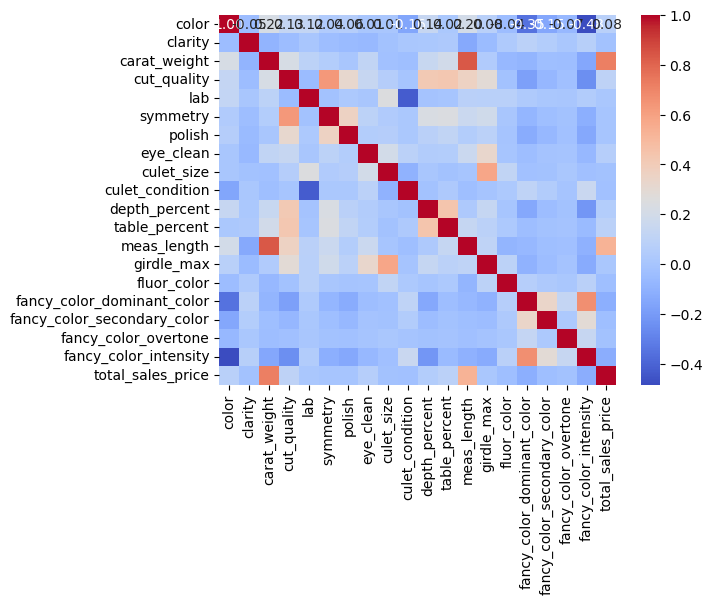

In [32]:
# Calculate the correlation matrix
df_processed_enc_scaled = pd.DataFrame(StandardScaler(with_mean=False).fit_transform(df_processed_enc), 
                                       columns=df_processed_enc.columns)
corr_matrix = df_processed_enc_scaled.corr()

# Select the features that are most strongly associated with price
features_corr = corr_matrix['total_sales_price'].abs().sort_values(ascending=False)

# Print the top 10 features
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
print(features_corr)

**Note:** How can we optimize our predictive model?
- Observe how most of the categorical variables have the least feature importance, hence we will compare models trained on data where categorical features are encoded with i) ordered encoding where aplicable and ii) one-hot encoding
- We will normalize the numeric features and evaluate model
- We will train the model with the top features and evaluate model 

### i) Normalization

In [35]:
numeric_processed_columns = [x for x in df_processed.columns if df_processed[x].dtype != 'object']
numeric_processed_X_columns = numeric_processed_columns.copy()
numeric_processed_X_columns.remove('total_sales_price')

In [36]:
# Compare different scalers on base model
scalers = [RobustScaler(), StandardScaler(with_mean=False, with_std=True), MinMaxScaler(), Normalizer(norm='l2'), 
           QuantileTransformer(output_distribution='normal'), PowerTransformer(method='box-cox'), PowerTransformer(method='yeo-johnson')]

temp2_df = df_processed_enc.copy()
# temp2_df['total_sales_price'] = np.log(temp2_df['total_sales_price'])
# temp2_df['total_sales_price'] = QuantileTransformer(output_distribution='normal').fit_transform(temp2_df['total_sales_price'].values.reshape(-1,1))

for scaler in scalers:
    print(scaler.__class__.__name__)
    temp_df = temp2_df.copy()
    temp_df[numeric_processed_X_columns] = scaler.fit_transform(temp_df[numeric_processed_X_columns])

    X1_train, X1_test, y1_train, y1_test = split_data(temp_df)
    evaluate_model(RidgeCV(alphas=(np.logspace(-3, 3, 10))), X1_train, X1_test, y1_train, y1_test)
    print('\n')

RobustScaler
RMSE: 11252.496082462809
R^2: 0.6145482307403387
MAE: 3615.80017695548
MAPE:  1.4678726233114712


StandardScaler
RMSE: 11252.466782906773
R^2: 0.6145502380373733
MAE: 3615.5369554557465
MAPE:  1.4676939854727347


MinMaxScaler
RMSE: 11252.610815730914
R^2: 0.6145403703747239
MAE: 3617.207491734653
MAPE:  1.4684409984941957


Normalizer
RMSE: 11311.39229063389
R^2: 0.6105027179338278
MAE: 3742.046480263844
MAPE:  1.561468247809831


QuantileTransformer
RMSE: 15550.920611396903
R^2: 0.2638191583640097
MAE: 6227.039066557983
MAPE:  3.2337978018951294


PowerTransformer
RMSE: 15703.932891649305
R^2: 0.24926067758194992
MAE: 5763.465121170033
MAPE:  2.561807015378504


PowerTransformer
RMSE: 16001.551094687551
R^2: 0.22053527129940154
MAE: 5793.174573046151
MAPE:  2.437216083828696




**Note:**

From above we can see that yeo-jhonson/box-cox Power Transformer and quantile transformer are the 2 best scalers to standardize the numeric features after the target is transformed.

### ii) Encoding

In [37]:
# Reorder categorical columns for ordered encoding
ordered_columns = [ 'color', 'clarity','cut_quality', 'symmetry', 'polish', 'culet_size', 'fancy_color_intensity']
unordered_columns = [x for x in categorical_columns if x not in ordered_columns]

# cat_values.loc['color',0] = ['unknown','M','L','K','J','I','H','G','F','E','D']
cat_values.loc['color',0] = ['M','L','K','J','I','H','G','F','E','D']
# cat_values.loc['color',0] = ['unknown', 'faint color', 'near colorless', 'colorless']

# cat_values.loc['clarity',0] = ['unknown','I3', 'I2', 'I1','SI3', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
cat_values.loc['clarity',0] = ['I3', 'I2', 'I1','SI3', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
# cat_values.loc['clarity',0] = ['unknown', 'I', 'SI', 'VS', 'VVS', 'IF']

# list1 = ['unknown', 'Poor','Fair', 'Good', 'Very Good', 'Excellent', 'Ideal']
list1 = [ 'Poor','Fair', 'Good', 'Very Good', 'Excellent', 'Ideal']
cat_values.loc['cut_quality',0] = list1
cat_values.loc['symmetry',0] = list1
cat_values.loc['polish',0] = list1

cat_values.loc['eye_clean',0] = ['unknown', 'No', 'Borderline', 'E1', 'Yes']
cat_values.loc['culet_size',0] = ['unknown', 'N', 'VS', 'S', 'M', 'SL', 'L', 'VL', 'EL']

list2 = ['unknown', 'XTN', 'VTN', 'TN', 'STN', 'M', 'STK', 'TK', 'VTK', 'XTK']
cat_values.loc['girdle_min',0] = list2
cat_values.loc['girdle_max',0] = list2

cat_values.loc['fancy_color_intensity',0] = ['Faint', 'Very Light', 'Light', 'Fancy Light', 'Fancy', 'Fancy Intense', 'Fancy Vivid', 'Fancy Dark', 'Fancy Deep']

RMSE: 11123.510679542615
R^2: 0.6233343167803047
MAE: 3806.4001431893366
MAPE:  1.7269019835779846


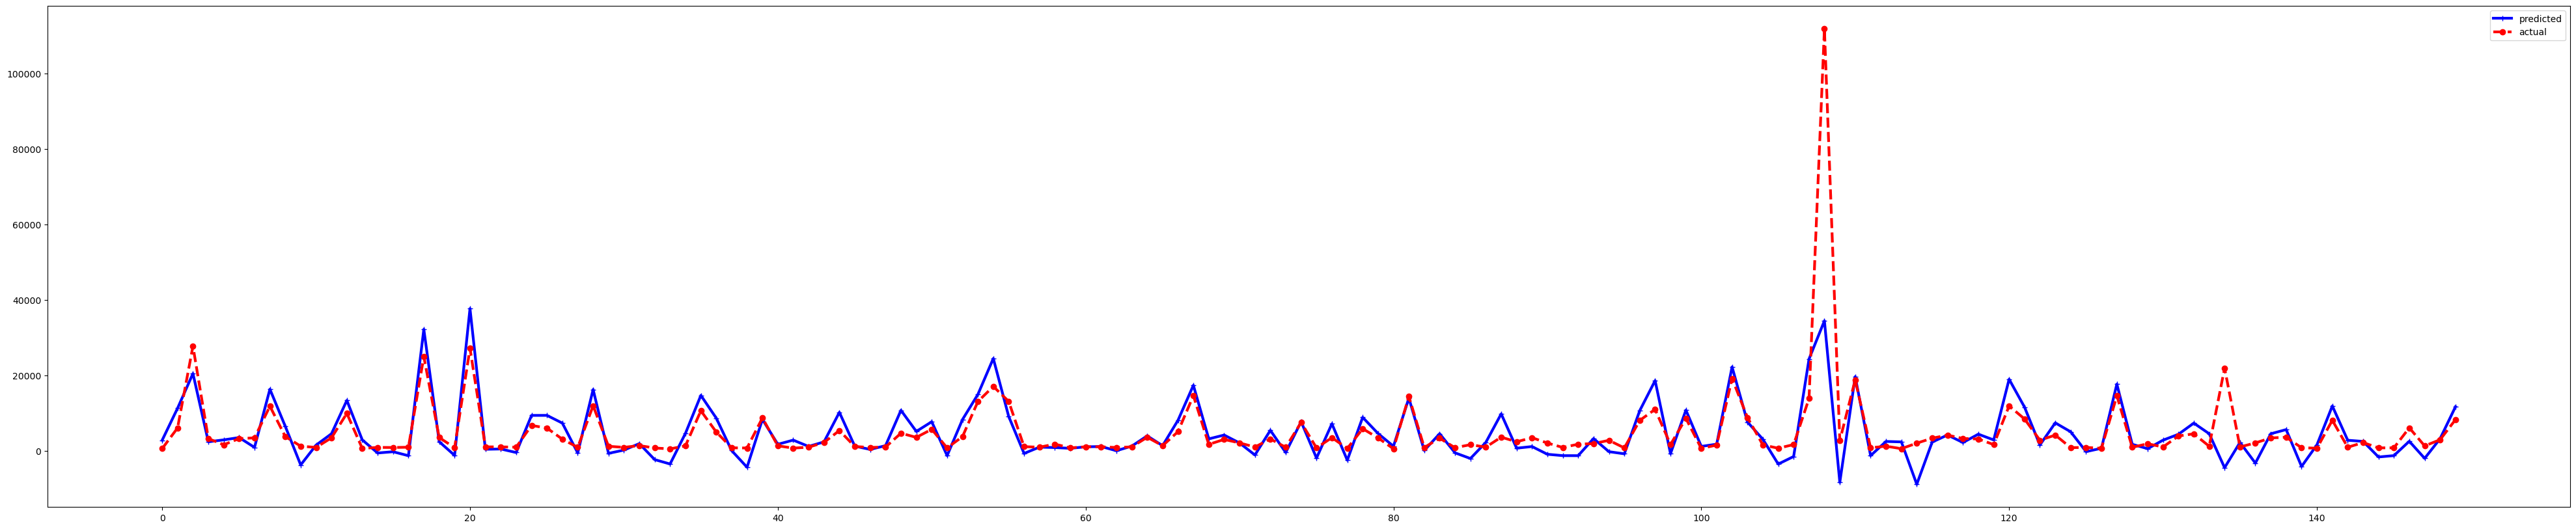

In [38]:
# Ordinal Encoding Model
# df = df_clean.copy()
X_train, X_test, y_train, y_test = split_data(df_processed)

enc = OrdinalEncoder(categories=cat_values[0][categorical_columns].to_list(), handle_unknown='use_encoded_value', unknown_value=-1)
enc.fit(X_train[categorical_columns])

X_train[categorical_columns] = enc.transform(X_train[categorical_columns])
X_test[categorical_columns] = enc.transform(X_test[categorical_columns])

# Train the model
ordinal_model = evaluate_model(RidgeCV(alphas=(np.logspace(-3, 3, 10))), X_train, X_test, y_train, y_test)

# Save the model
save_model(ordinal_model, 'ordinal_model')

# Plot the model
# plot_model(ordinal_model, X_test, y_test)
plot_fit(ordinal_model, X_test, y_test)

RMSE: 10775.570301258434
R^2: 0.6465297785897375
MAE: 3733.1876731059197
MAPE:  1.6893254549115653


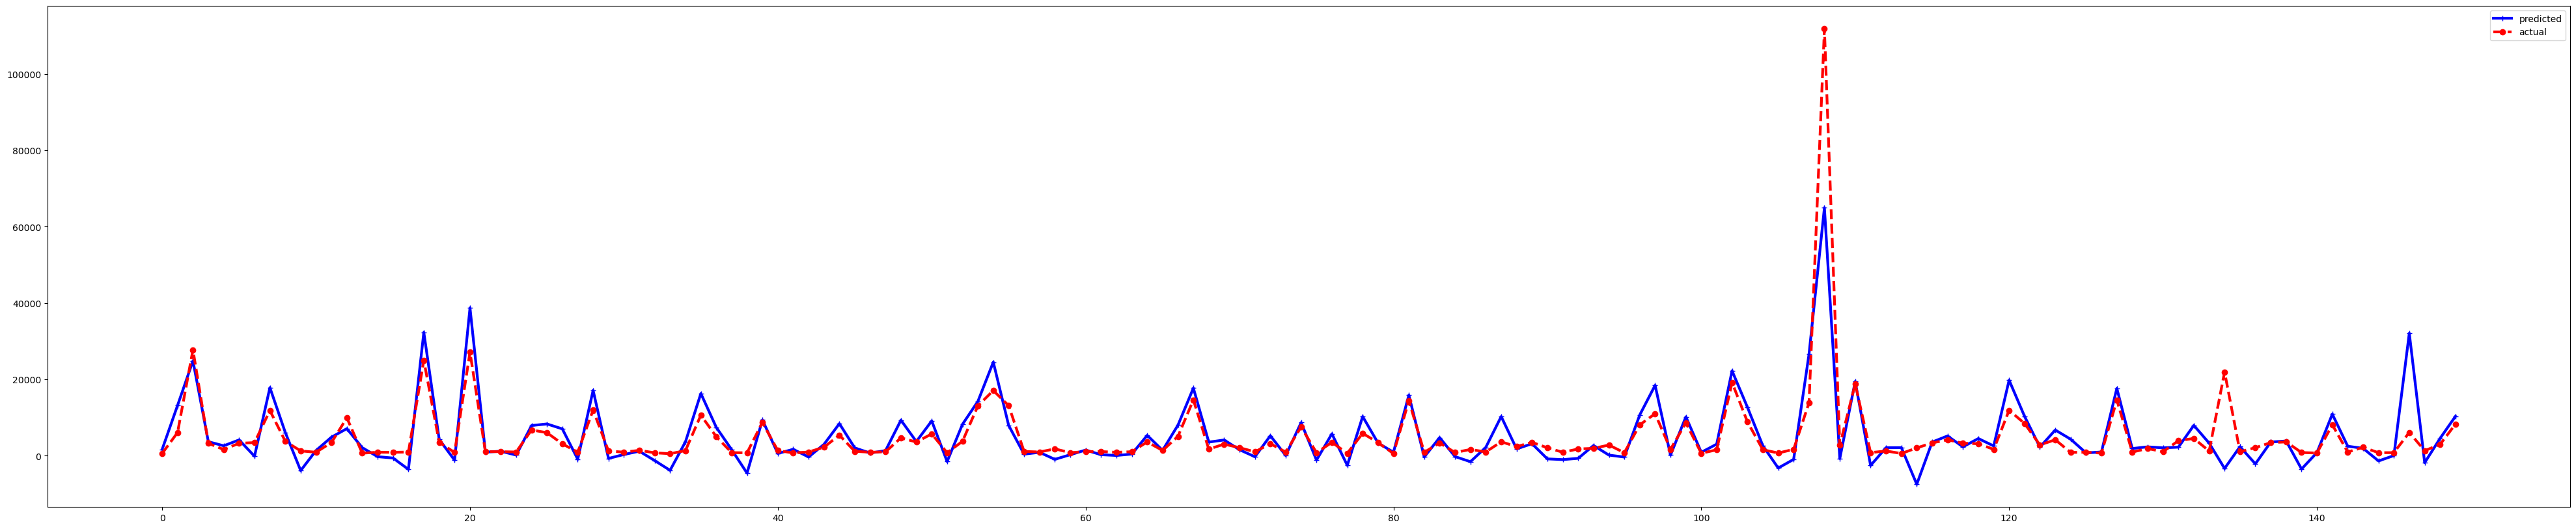

In [39]:
# One Hot Encoding Model
X_train, X_test, y_train, y_test = split_data(df_processed_enc)

preprocessor_one_hot = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    remainder='passthrough',
    verbose_feature_names_out=False
)

one_hot_model = make_pipeline(preprocessor_one_hot, RidgeCV(alphas=(np.logspace(-3, 3, 10))))
one_hot_model = evaluate_model(one_hot_model, X_train, X_test, y_train, y_test)
save_model(one_hot_model, 'one_hot_model')
plot_fit(one_hot_model, X_test, y_test)

**Note:**

Although One Hot Encoding results in lower error, it increses the dimensionality of the data many folds and is memory extensive, so we will be sticking with ordinal encoding for the categorical features.

In [40]:
# Pipelines to preprocess data
cat_pipeline_one_hot = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

cat_pipeline_ordinal = Pipeline([
    ('ordinal', OrdinalEncoder(categories=cat_values[0][categorical_columns].to_list(), 
                               handle_unknown='use_encoded_value', 
                            unknown_value=-1)),
])


# Preprocessors with different pipelines for numeric and categorical columns
preprocessor_one_hot_standard = ColumnTransformer([
    ('onehot', cat_pipeline_one_hot, categorical_columns),
    ('scaler', StandardScaler(), numeric_columns),
    'passthrough'
])

preprocessor_ordinal =  make_column_transformer(
    (cat_pipeline_ordinal, categorical_columns),
    remainder='passthrough',
    verbose_feature_names_out=False
)

preprocessor_normalize = ColumnTransformer([
    ('normalizer', Normalizer(norm='l2'), numeric_columns),
    'passthrough',
])

preprocessor_power = ColumnTransformer([
    ('power', PowerTransformer(method='box-cox'), numeric_columns),
    'passthrough'])

preprocessor_standard = make_column_transformer(
    (StandardScaler(with_mean=False), numeric_columns),
    remainder='passthrough',
    verbose_feature_names_out=False
)

#### Feature Selection

In [41]:
# # Correlation Analysis
# df = df.sample(frac=1).reset_index(drop=True)
# corr = df.corr(method='spearman')
# plt.figure(figsize=(20, 20))
# sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
# plt.show()

In [42]:
# # Selecting features
# k = 10
# features = corr['total_sales_price'].abs().sort_values(ascending=False)
# print(features)

# top_features = features.index[:k]

### iii) Model Selection

In [43]:
# prepare the data for modeling
df_sample = df_processed_enc.sample(frac=1, random_state=42)
df_sample = df_sample.reset_index(drop=True)

X, y = df_sample.drop('total_sales_price', axis=1), df_sample['total_sales_price']

# Building Pipelines
pipe_lr = make_pipeline(LinearRegression())
pipe_ridge = make_pipeline(RidgeCV(alphas=(np.logspace(-3, 3, 10))))
pipe_poly = make_pipeline(PolynomialFeatures(degree=2), LinearRegression(fit_intercept=False))
pipe_svm = make_pipeline(svm.SVR(kernel='linear'))
pipe_dtr = make_pipeline(DecisionTreeRegressor(max_depth=12))
pipe_rf = make_pipeline(RandomForestRegressor(n_estimators=10))
pipe_knn = make_pipeline(KNeighborsRegressor(n_neighbors=10))
pipe_sgd = make_pipeline(SGDRegressor(fit_intercept=False))
pipe_xgb = make_pipeline(XGBRegressor(n_estimators=10))
pipe_gb = make_pipeline(GradientBoostingRegressor(n_estimators=10))
pipe_hgb = make_pipeline(HistGradientBoostingRegressor(max_iter=100, max_depth=12))
pipe_et = make_pipeline(ExtraTreesRegressor(n_estimators=10))
pipe_ada = make_pipeline(AdaBoostRegressor(n_estimators=10))


# Train the models
models = [pipe_lr, pipe_ridge, pipe_poly, pipe_dtr, pipe_rf, pipe_knn, pipe_sgd, pipe_xgb, pipe_hgb, pipe_gb, pipe_et, pipe_ada]
for model in models:
    print(f"{model.__getattribute__('steps')[0][0]}")
    cv_results = cross_validate(model, X, y, cv=5, 
                                scoring=('r2','neg_root_mean_squared_error', 'neg_mean_absolute_error'))
    print(f'Mean Absolute Error: {-cv_results["test_neg_mean_absolute_error"].mean()} +/- {cv_results["test_neg_mean_absolute_error"].std()}\n')

linearregression
Mean Absolute Error: 3648.565689095074 +/- 42.236519813343044

ridgecv
Mean Absolute Error: 3645.411785124984 +/- 43.291626151747096

polynomialfeatures
Mean Absolute Error: 177429.55386475127 +/- 349837.9278061081

decisiontreeregressor
Mean Absolute Error: 1153.0092279886528 +/- 76.06688667161191

randomforestregressor
Mean Absolute Error: 899.4376481841464 +/- 51.502081715730704

kneighborsregressor
Mean Absolute Error: 2191.8394083012777 +/- 44.455262989293864

sgdregressor
Mean Absolute Error: 5564.539840292879 +/- 1723.3523849885266

xgbregressor
Mean Absolute Error: 1360.0470438336845 +/- 39.14975776889894

histgradientboostingregressor
Mean Absolute Error: 1048.6958437932399 +/- 26.375309130126112

gradientboostingregressor
Mean Absolute Error: 3295.8075419740007 +/- 42.885265870989066

extratreesregressor
Mean Absolute Error: 881.7586941700378 +/- 44.318989712550014

adaboostregressor
Mean Absolute Error: 4681.473956575678 +/- 794.8260980250174



**Note:**

We can see that out of all the models we've tested above, extra trees regressor is the best one followed by random forest regressor and hist gradient boosting regressor.

### Best Model

In [45]:
# Prepare the data
X_train, X_test, y_train, y_test = split_data(df_processed)

# Preprocessing
num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    PowerTransformer(method='yeo-johnson'),
)

cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(categories=cat_values[0][categorical_columns].to_list(),
                   handle_unknown='use_encoded_value',
                   unknown_value=-1)
)

preprocessor = make_column_transformer(
    (num_pipeline, ['carat_weight']),
    (cat_pipeline, X_train.select_dtypes(include='object').columns),
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Model
model = make_pipeline(
    preprocessor,
    ExtraTreesRegressor(n_estimators=100, max_depth=12, random_state=rng)
)

# Define target transformer
wrapped_model = TransformedTargetRegressor(
    regressor=model,
    transformer=QuantileTransformer(output_distribution='normal')
)

# Perform cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=rng)
scores = cross_val_score(model, X_train, y_train, cv=cv)
print(f'Mean Validation R2: {scores.mean()} +/- {scores.std()}')

Mean Validation R2: 0.8689104320899681 +/- 0.026515784202597627


In [46]:
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['carat_weight']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEnc...
                                                  Index(['color', 'clarity', 'cut_quality', 'lab', 'symmetry', 'polish',
       'eye_clean', 'culet_size', 'culet_condition', 'girdle_max',
       'fluor_color', 'fancy_color_dominant_color',
       'fancy_color_secondary_color', 'fancy_color_overtone',
       'fancy_color_intensity'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('extratreesregressor',
                 ExtraTreesRegressor(max_depth=12,
                                     random_state=RandomState(MT19937) at 0x20E3D4EE840))])

In [47]:
print(model)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('powertransformer',
                                                                   PowerTransformer())]),
                                                  ['carat_weight']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                

In [48]:
model.named_steps['columntransformer']._transformers[0][1].get_params()

{'memory': None,
 'steps': [('simpleimputer', SimpleImputer(strategy='median')),
  ('powertransformer', PowerTransformer())],
 'verbose': False,
 'simpleimputer': SimpleImputer(strategy='median'),
 'powertransformer': PowerTransformer(),
 'simpleimputer__add_indicator': False,
 'simpleimputer__copy': True,
 'simpleimputer__fill_value': None,
 'simpleimputer__keep_empty_features': False,
 'simpleimputer__missing_values': nan,
 'simpleimputer__strategy': 'median',
 'powertransformer__copy': True,
 'powertransformer__method': 'yeo-johnson',
 'powertransformer__standardize': True}

In [49]:
# Train the model
model.fit(X_train, y_train)

# Save model
save_model(model, 'final_predictive_model')

## Prediction

R^2: 0.8669797767545493
RMSE: 6610.323059999843
MAE: 931.435810151053


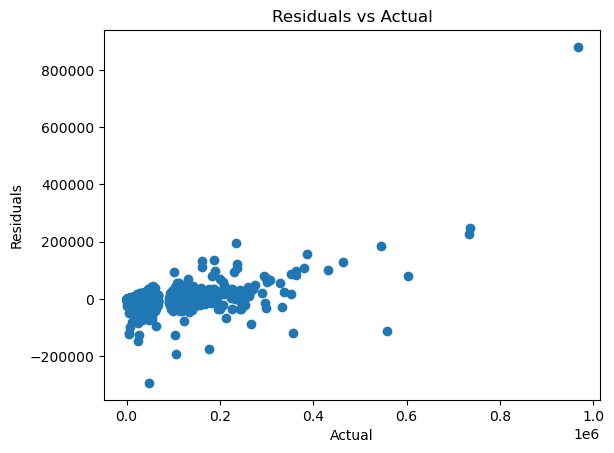

In [50]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R^2: {r2}")
print(f"RMSE: {np.sqrt(mse)}")
print(f"MAE: {mae}")

# Residual Analysis - check for homoscedasticity
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual')
plt.show()

# # Residual Analysis - check for normality
# sns.displot(residuals, bins=50)
# plt.xlabel('Residuals')
# plt.ylabel('Frequency')
# plt.title('Distribution of Residuals')
# plt.show()

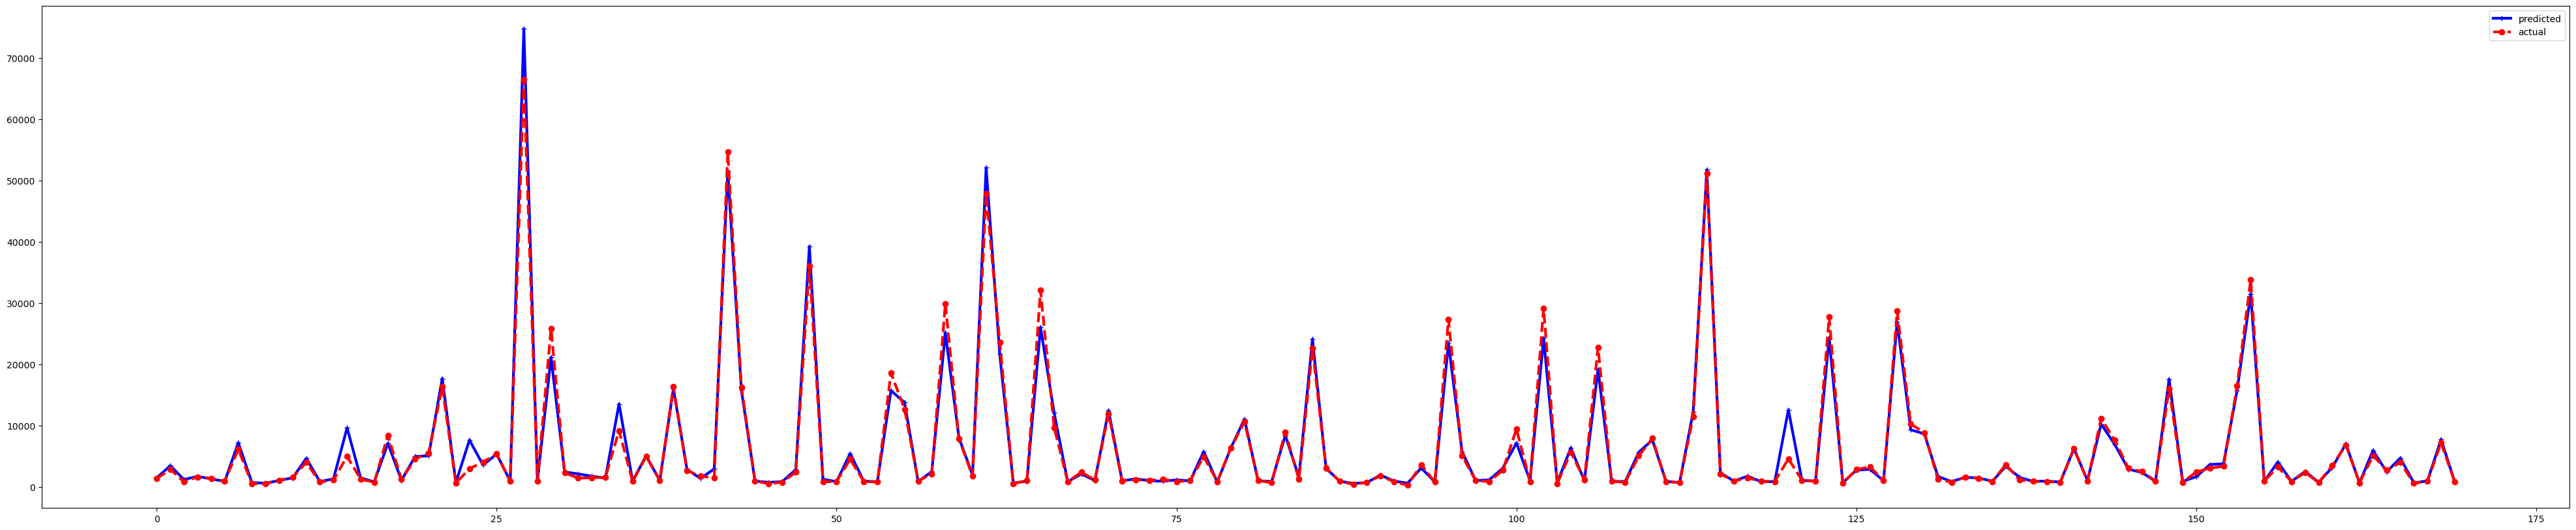

In [51]:
# Plot the model
y_pred = y_pred.reshape(y_test.shape[0], 1)
y_test = y_test.to_numpy().reshape(y_test.shape[0], 1)
plt.figure(figsize=(50,10))
plt.plot(y_pred[3100:3270], 'b+-', label='predicted', linewidth=3)
plt.plot(y_test[3100:3270],'ro--',label='actual', linewidth=3)
plt.legend()
plt.show()